# Kaggle cats-or-dogs binary classification

* Building a convolutional neural network for binary classification of images.
* 3,000 JPG pictures of cats and dogs from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle.
* Transfer learning from an existing Inception V3
* Data augmentation and dropout for avoiding overffiting
* History of training/validation accuracy and loss.

Retrain an existing Inception V3 that is already trained with much more data set

Optimizer: RMSprop with learning rate = 0.001

Loss function: binary cross-entropy

## Download the cat and dog images

In [1]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O ~/Downloads/cats_and_dogs_filtered.zip

--2019-07-28 16:27:23--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2607:f8b0:4009:806::2010, 172.217.4.208
Connecting to storage.googleapis.com (storage.googleapis.com)|2607:f8b0:4009:806::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/Users/johanzhuohan/Downloads/cats_and_dogs_filtered.zip’

/Users/johanzhuohan 100%[===================>]  65.43M  51.4MB/s    in 1.3s    

2019-07-28 16:27:25 (51.4 MB/s) - ‘/Users/johanzhuohan/Downloads/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
import os
import zipfile

local_zip = '/Users/johanzhuohan/Downloads/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/Users/johanzhuohan/Downloads')
zip_ref.close()

In [3]:
base_dir = '/Users/johanzhuohan/Downloads/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_cats_names = os.listdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
train_dogs_names = os.listdir(train_dogs_dir)

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [4]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


## Downloading trained inception neural network: transfer learning

In [5]:
from tensorflow.keras import layers
from tensorflow.keras import Model

# Download the existing model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# import the model skeleton
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Fill in the existing model to the skeleton
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, # ignore the first default dence layer
                                weights = None)
pre_trained_model.load_weights(local_weights_file)

# Lock the convolution layers
for layer in pre_trained_model.layers:
   layer.trainable = False
  
# pre_trained_model.summary()

# Get the output from the last convolution layer
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2019-07-28 16:31:04--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 2607:f8b0:4009:806::2010, 172.217.4.208
Connecting to storage.googleapis.com (storage.googleapis.com)|2607:f8b0:4009:806::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  40.4MB/s    in 2.1s    

2019-07-28 16:31:06 (40.4 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



W0728 16:31:06.511591 140734869591488 deprecation.py:506] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


last layer output shape:  (None, 7, 7, 768)


## Training a Convolutional neural network without dropout

Here we will train a model with augmented data set, but without dropout.

In [25]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)                 
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

* Set the optimizer and the loss function
* Try 'sgd', or 'Adam' for optimizer

In [26]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

* Data processing with data augmentation for train set

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation for train data set
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     

validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


* Training without dropout

In [ ]:
history = model.fit_generator(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              epochs=40,
                              validation_steps=50,
                              verbose=1)

Epoch 1/40
100/100 [==============================] - 149s 1s/step - loss: 0.8599 - acc: 0.7325 - val_loss: 0.8846 - val_acc: 0.8450

## Accuracy and Loss history without dropout

* Accuracy > ~ 80 % can be got without dropout.
* The fluctuation in validation loss is large, and the validation loss is slightly increasing overall, which is a sign of overfitting.

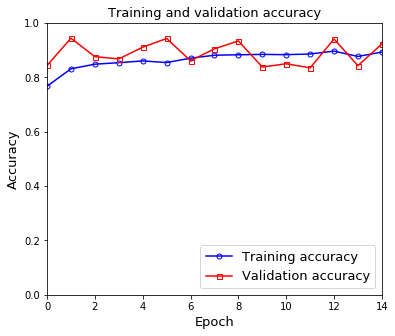

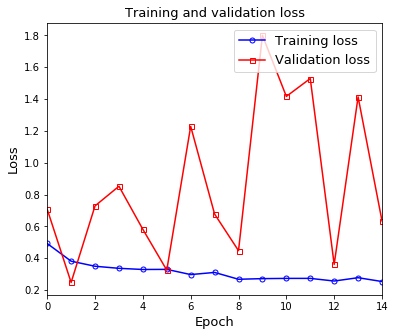

In [13]:
import matplotlib.pyplot as plt

acc = history.history[ 'acc' ]
val_acc = history.history[ 'val_acc' ]
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]

epochs = range(len(acc)) # Get number of epochs

markers = 5
font = 13
# Accuracy
fig, ax = plt.subplots(figsize = (6,5))
ax.plot  ( epochs, acc, 'bo-', label='Training accuracy', markerfacecolor="None",markersize=markers )
ax.plot  ( epochs, val_acc, 'rs-', label='Validation accuracy', markerfacecolor="None",markersize=markers )
ax.set_title ('Training and validation accuracy', fontsize=font)
ax.set_xlabel('Epoch', fontsize=font)
ax.set_ylabel('Accuracy', fontsize=font)
ax.set(xlim=[0,epochs[-1]], ylim=[0.0,1.0])
ax.legend(loc='lower right',frameon=True,fontsize=font)

# Loss
fig, ax = plt.subplots(figsize = (6,5))
plt.plot  ( epochs, loss, 'bo-', label='Training loss', markerfacecolor="None",markersize=markers )
plt.plot  ( epochs, val_loss, 'rs-', label='Validation loss', markerfacecolor="None",markersize=markers )
plt.title ('Training and validation loss'   )
ax.set_title ('Training and validation loss', fontsize=font)
ax.set_xlabel('Epoch', fontsize=font)
ax.set_ylabel('Loss', fontsize=font)
ax.set(xlim=[0,epochs[-1]],ylim=[0,2.0])
ax.legend(loc='upper right',frameon=True,fontsize=font)
plt.show()

## Training a Convolutional neural network with dropout

Here we will train a model with augmented data set and with dropout. It will be clear, dropout can help train the model better. This is because in NN, neighbor neurons somtimes learn similar features, and skew the model to some specific features, resulting in overfitting. By randomly dropping out some of the neurons, overfitting can be possiblly avoided.

In [14]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)                 
# Dropout 20 %
x = layers.Dropout(0.2)(x)
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

In [15]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

* Data augmentation

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for the training data set
train_datagen = ImageDataGenerator( 
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest' )
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))   

# Validation data set
validation_datagen  = ImageDataGenerator( rescale = 1.0/255. )

validation_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


* Training with dropout

In [17]:
history = model.fit_generator(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              epochs=40,
                              validation_steps=50,
                              verbose=1)

Epoch 1/15
100/100 [==============================] - 213s 2s/step - loss: 1.0512 - acc: 0.7110 - val_loss: 0.6847 - val_acc: 0.8460

## Accuracy and Loss history with dropout

* As it can be seen, training the CNN model with dropout makes the fluctuations in loss smaller.
* The validation accuracy stays ~ 90% during training.

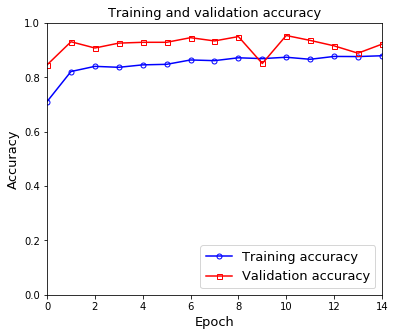

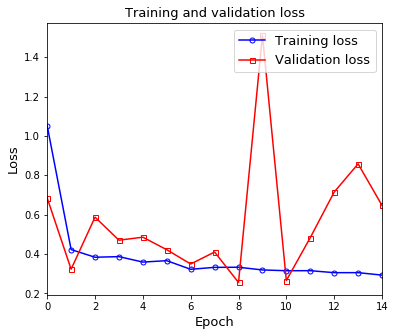

In [24]:
import matplotlib.pyplot as plt

acc = history.history[ 'acc' ]
val_acc = history.history[ 'val_acc' ]
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]

epochs = range(len(acc)) # Get number of epochs

markers = 5
font = 13
# Accuracy
fig, ax = plt.subplots(figsize = (6,5))
ax.plot  ( epochs, acc, 'bo-', label='Training accuracy', markerfacecolor="None",markersize=markers )
ax.plot  ( epochs, val_acc, 'rs-', label='Validation accuracy', markerfacecolor="None",markersize=markers )
ax.set_title ('Training and validation accuracy', fontsize=font)
ax.set_xlabel('Epoch', fontsize=font)
ax.set_ylabel('Accuracy', fontsize=font)
ax.set(xlim=[0,epochs[-1]], ylim=[0.0,1.0])
ax.legend(loc='lower right',frameon=True,fontsize=font)

# Loss
fig, ax = plt.subplots(figsize = (6,5))
plt.plot  ( epochs, loss, 'bo-', label='Training loss', markerfacecolor="None",markersize=markers )
plt.plot  ( epochs, val_loss, 'rs-', label='Validation loss', markerfacecolor="None",markersize=markers )
plt.title ('Training and validation loss'   )
ax.set_title ('Training and validation loss', fontsize=font)
ax.set_xlabel('Epoch', fontsize=font)
ax.set_ylabel('Loss', fontsize=font)
ax.set(xlim=[0,epochs[-1]],ylim=[0,2.0])
ax.legend(loc='upper right',frameon=True,fontsize=font)
plt.show()